In [2]:
import featuretools as ft
import pandas as pd
import numpy as np
import seaborn as sns
import simfin as sf
import math
import datetime as date
from datetime import timedelta  
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from statsmodels.tsa.arima_model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
import warnings
warnings.filterwarnings("ignore")

## Mean Reversion on Equities: Implementation of Statistical Arbitrage Fundamental and estimation on alpha using the Ornstein-Ulhenbeck Process

In [391]:
#collect data from api
sf.set_api_key('PLEbHyzQgm98TrvHFejzBwikq1mKiJob ')
sf.set_data_dir('~/simfin_data/')
sf.set_data_dir('C:/Users/suher/Python/Springboard/Capstone 2')
figures_and_ratios = sf.load_derived(variant = 'quarterly',market = 'us')
sector_industry = sf.load_industries()
balance_sheet = sf.load_balance(variant='quarterly-full', market='us')
companies = sf.load_companies(market='us')
cash_flow = sf.load_cashflow(variant='quarterly-full', market='us')
income_statement = sf.load_income(variant='quarterly-full', market='us')
historical_prices = sf.load_shareprices(variant = 'daily', market = 'us')
price_ratios = sf.load_derived_shareprices(variant='daily', market='us')


sp500_daily = pd.read_csv('sp500daily.csv')
sp500_list = list(pd.read_csv('constituents_csv.csv')['Symbol'])
sp500_daily.Date =  pd.to_datetime(sp500_daily.Date)

hp = historical_prices.reset_index()
hp = hp[hp['Ticker'].isin(sp500_list)]
companies = companies.reset_index()
companies = companies[companies['Ticker'].isin(sp500_list)]

sector_industry.Sector.unique()

sp500_daily.set_index('Date',inplace=True)

sector_industry.reset_index(inplace=True)
comp_sector = pd.merge(companies,sector_industry,how='left',left_on='IndustryId',right_on='IndustryId')

hp_ = pd.merge(hp,comp_sector[['SimFinId','Sector']],how='left',left_on='SimFinId',right_on='SimFinId')

t_hp = hp_[hp_['Sector'] == 'Technology']
f_hp = hp_[hp_['Sector'] == 'Financial Services']
s_hp = sp500_daily[['Open','Close']]

s_open = s_hp.Open
s_close = s_hp.Close
t_open = t_hp.set_index('Date').pivot(columns='Ticker',values='Open')
t_close = t_hp.set_index('Date').pivot(columns='Ticker',values='Close')
f_open = f_hp.set_index('Date').pivot(columns='Ticker',values='Open')
f_close = f_hp.set_index('Date').pivot(columns='Ticker',values='Close')

st_close = pd.DataFrame(s_close).join(t_close)
st_close.rename(columns={'Close':'SPX'},inplace=True)
st_close_ret = st_close.pct_change().iloc[1:,:]

Dataset "us-derived-quarterly" on disk (10 days old).
- Loading from disk ... Done!
Dataset "industries" on disk (10 days old).
- Loading from disk ... Done!
Dataset "us-balance-quarterly-full" on disk (8 days old).
- Loading from disk ... Done!
Dataset "us-companies" on disk (10 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-quarterly-full" on disk (8 days old).
- Loading from disk ... Done!
Dataset "us-income-quarterly-full" on disk (8 days old).
- Loading from disk ... Done!
Dataset "us-shareprices-daily" on disk (10 days old).
- Loading from disk ... Done!
Dataset "us-derived-shareprices-daily" on disk (10 days old).
- Loading from disk ... Done!


In [395]:
historical_prices.loc['AAPL']

,SimFinId,Open,Low,High,Close,Adj. Close,Dividend,Volume,Shares Outstanding
Date,,,,,,,,,
2007-01-03,111052,3.08,2.92,3.09,2.99,2.59,NaN,44225700,NaN
2007-01-04,111052,3.00,2.99,3.07,3.06,2.64,NaN,30259300,NaN
2007-01-05,111052,3.06,3.01,3.08,3.04,2.62,NaN,29812200,NaN
2007-01-08,111052,3.07,3.05,3.09,3.05,2.64,NaN,28468100,NaN
2007-01-09,111052,3.09,3.04,3.32,3.31,2.86,NaN,119617800,NaN
...,...,...,...,...,...,...,...,...,...
2020-10-19,111052,119.96,115.66,120.42,115.98,115.98,NaN,120639337,1.710254e+10
2020-10-20,111052,116.20,115.63,118.98,117.51,117.51,NaN,124423728,1.710254e+10
2020-10-21,111052,116.67,116.45,118.70,116.87,116.87,NaN,89945980,1.710254e+10



Check daily returns data integrity by testing stationarity (anderson-fuller test).

In [10]:
st_close_ret

,SPX,AAPL,ADBE,ADI,ADSK,AKAM,AMAT,AMD,ANET,ANSS,...,SWKS,TEL,TTWO,TWTR,TXN,TYL,VRSN,WDC,XLNX,XRX
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.003116,0.002618,0.016446,-0.001579,-0.015193,0.029707,-0.007692,0.001031,NaN,-0.022401,...,0.015520,-0.014782,0.006731,NaN,-0.005767,0.023645,0.010509,0.026513,-0.012608,0.001159
2010-01-06,0.000546,-0.016971,-0.002122,-0.001898,0.002373,-0.008243,-0.002114,-0.014418,NaN,-0.006645,...,-0.009302,0.020276,-0.002865,NaN,-0.007347,-0.000481,-0.010800,0.000861,-0.006784,-0.009259
2010-01-07,0.004001,-0.001328,-0.019405,-0.007921,0.005525,0.000378,-0.010593,-0.010449,NaN,0.002537,...,-0.011402,-0.018680,-0.004789,NaN,0.003116,-0.013000,-0.013748,-0.019570,-0.010044,0.004673
2010-01-08,0.002882,0.006649,-0.005422,0.005749,0.030612,0.000000,0.038544,-0.004224,NaN,0.006903,...,0.017639,0.012556,0.002887,NaN,0.022913,0.011707,0.007790,0.005045,0.014610,-0.003488
2010-01-11,0.001747,-0.009247,-0.013083,-0.005716,-0.000381,-0.003399,0.021993,-0.030753,NaN,0.003885,...,0.000667,-0.008800,0.024952,NaN,-0.012908,-0.011090,-0.002848,0.001091,-0.010400,0.024504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,-0.000195,0.000986,0.002098,0.004615,0.005412,-0.002095,0.006876,0.023757,-0.001123,0.002972,...,0.017746,0.001262,0.014821,0.002158,-0.000156,0.003295,0.001663,-0.007496,-0.004146,0.000535
2019-12-26,0.005128,0.019840,0.004732,0.000084,0.001794,0.007115,-0.003089,0.001934,0.004740,0.007174,...,0.000982,0.001155,0.000484,0.004000,-0.000389,0.006870,0.004981,0.009160,0.001929,0.002944
2019-12-27,0.000034,-0.000414,-0.001238,-0.002339,0.006188,0.001853,-0.002283,-0.009650,-0.005739,0.001355,...,0.000082,0.002098,0.003871,-0.002452,0.000700,0.000433,0.001755,-0.010669,-0.002635,-0.004536


In [11]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(df): 
    adf_scores = []
    for i in list(df.columns): 
        curr_adf = adfuller(df[i].dropna())
        if curr_adf[1] > .05: 
            print('return of '+ i +'is not stationary')
        adf_scores.append(curr_adf[1])
    print(adf_scores)   
    
check_stationarity(st_close_ret)

[5.553316228250892e-21, 0.0, 0.0, 0.0, 4.9922408583287756e-27, 0.0, 2.038736506225406e-30, 0.0, 0.0, 0.0, 0.0, 4.381051964154431e-29, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.493561648922373e-26, 0.0, 0.0, 0.0, 0.0, 4.38949639290485e-26, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.360825648999867e-30, 0.0, 0.0, 0.0, 8.111678817735038e-28, 1.6110881279268902e-27, 7.96407307737618e-18, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.904098580702446e-19, 0.0, 0.0, 0.0, 0.0, 0.0]


Checking integrity of data returns are stationary, proceeding to EDA on tech daily returns.

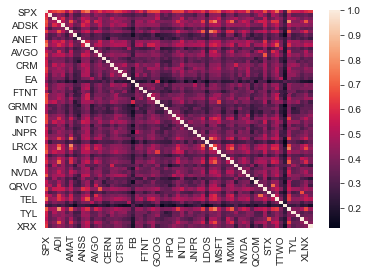

In [12]:
st_cormat = st_close_ret.corr()

sns.heatmap(st_cormat)

In [13]:
st_cormat.head()

,SPX,AAPL,ADBE,ADI,ADSK,AKAM,AMAT,AMD,ANET,ANSS,...,SWKS,TEL,TTWO,TWTR,TXN,TYL,VRSN,WDC,XLNX,XRX
SPX,1.000000,0.594454,0.640472,0.683298,0.653121,0.508136,0.647975,0.447742,0.405457,0.676361,...,0.583891,0.735098,0.498561,0.299533,0.702269,0.572662,0.565424,0.535550,0.589004,0.622795
AAPL,0.594454,1.000000,0.391650,0.451282,0.404948,0.288814,0.449266,0.301571,0.290395,0.420987,...,0.495559,0.443582,0.337278,0.246508,0.466154,0.336545,0.344159,0.342228,0.368228,0.328292
ADBE,0.640472,0.391650,1.000000,0.489951,0.597206,0.377447,0.474976,0.327088,0.381254,0.544977,...,0.385006,0.473604,0.417703,0.286828,0.488523,0.501832,0.426522,0.371542,0.436130,0.388711
ADI,0.683298,0.451282,0.489951,1.000000,0.518988,0.392218,0.668798,0.436903,0.336469,0.510570,...,0.623242,0.619291,0.385259,0.253183,0.790528,0.417567,0.409653,0.487627,0.687649,0.454002
ADSK,0.653121,0.404948,0.597206,0.518988,1.000000,0.403540,0.517180,0.360747,0.386889,0.593243,...,0.467301,0.539521,0.382253,0.293418,0.527280,0.456132,0.451628,0.433908,0.460370,0.418679


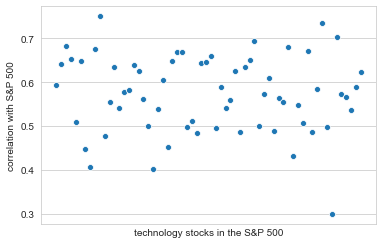

In [14]:
sns.set_style('whitegrid')
spcor = sns.scatterplot(x=st_cormat.columns[1:],y=st_cormat.SPX[1:]);
plt.ylabel('correlation with S&P 500');
plt.xlabel('technology stocks in the S&P 500');
spcor.axes.get_xaxis().set_ticks([]);

Test creating a base capm model.

In [15]:
tech_etf = ['IXN','IGM','IGV','XNTK','XLK','XSD','VGT','RYT','XSW']

etf_daily_close = pd.read_csv('IXN.csv')
etf_daily_close = etf_daily_close[['Date','Close']]
for i in tech_etf[1:]: 
    etf_csv = i +'.csv'
    etf_df = pd.read_csv(etf_csv)[['Date','Close']]
    etf_daily_close = pd.merge(etf_daily_close,etf_df,how='left',left_on='Date',right_on='Date')

pd.read_csv('IXN.csv').head()
etf_daily_close['Date'] = pd.to_datetime(etf_daily_close['Date'])
etf_daily_close.set_index('Date',inplace=True)
etf_daily_close.columns = tech_etf
etf_daily_ret = etf_daily_close.pct_change()[1:]
stETF = st_close_ret.join(etf_daily_ret)
stETF.head()


,SPX,AAPL,ADBE,ADI,ADSK,AKAM,AMAT,AMD,ANET,ANSS,...,XRX,IXN,IGM,IGV,XNTK,XLK,XSD,VGT,RYT,XSW
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.003116,0.002618,0.016446,-0.001579,-0.015193,0.029707,-0.007692,0.001031,NaN,-0.022401,...,0.001159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,0.000546,-0.016971,-0.002122,-0.001898,0.002373,-0.008243,-0.002114,-0.014418,NaN,-0.006645,...,-0.009259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,0.004001,-0.001328,-0.019405,-0.007921,0.005525,0.000378,-0.010593,-0.010449,NaN,0.002537,...,0.004673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,0.002882,0.006649,-0.005422,0.005749,0.030612,0.000000,0.038544,-0.004224,NaN,0.006903,...,-0.003488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,0.001747,-0.009247,-0.013083,-0.005716,-0.000381,-0.003399,0.021993,-0.030753,NaN,0.003885,...,0.024504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


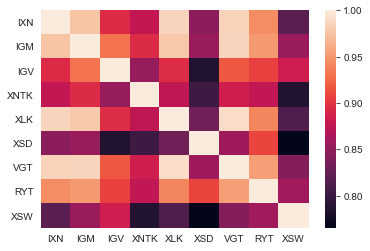

In [16]:
sns.heatmap(etf_daily_ret.corr())

trying in normal CAPM model on MSFT

In [19]:

import statsmodels.api as sm

stETF = st_close_ret.join(etf_daily_ret)

spx = stETF['SPX']
msft = stETF['MSFT']
x = sm.add_constant(spx)
lr = sm.OLS(msft,x)
results = lr.fit()
msft_spx = results.predict(x)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MSFT   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     2328.
Date:                Wed, 04 Nov 2020   Prob (F-statistic):               0.00
Time:                        03:35:10   Log-Likelihood:                 7932.8
No. Observations:                2515   AIC:                        -1.586e+04
Df Residuals:                    2513   BIC:                        -1.585e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.254      0.210      -0.000       0.001
SPX            1.0688      0.022     48.253      0.000       1.025       1.112
==============================================================================
Omnibus:                      598.950   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29908.667
Skew:                           0.187   Prob(JB):                         0.00
Kurtosis:                      19.890   Cond. No.                         108.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
np.cumprod(stETF['SPX']+1)

Date
2010-01-05    1.003116
2010-01-06    1.003663
2010-01-07    1.007679
2010-01-08    1.010583
2010-01-11    1.012348
                ...   
2019-12-24    2.845021
2019-12-26    2.859610
2019-12-27    2.859708
2019-12-30    2.843176
2019-12-31    2.851552
Name: SPX, Length: 2515, dtype: float64

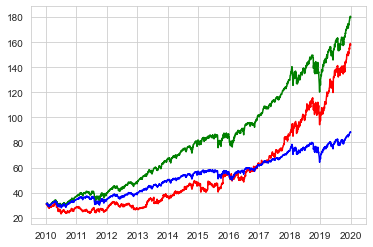

In [21]:
pred_msft = st_close.iloc[0]['MSFT'] * np.cumprod(msft_spx+1)
spx_ret = st_close.iloc[0]['MSFT'] * np.cumprod(stETF['SPX']+1)
plt.plot(st_close['MSFT'],'r')
plt.plot(pred_msft,'g')
plt.plot(spx_ret,'b')

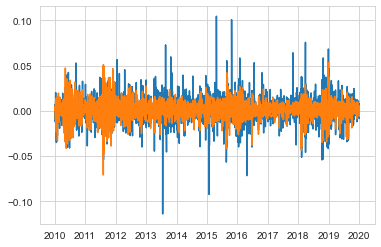

In [22]:
plt.plot(msft)
plt.plot(msft_spx)

In [23]:
x = stETF.loc[:,tech_etf].dropna()
y = stETF.loc[x.index[0]:x.index[-1],:]['MSFT']
#y = st_close_ret.loc[x.index[0],:]['GOOG'].dropna()
#x = st_close_ret.loc[y.index[0],:]['SPX']
x = sm.add_constant(x)
lr = sm.OLS(y,x)
results = lr.fit()
msft_etf = results.predict(x)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MSFT   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     381.6
Date:                Wed, 04 Nov 2020   Prob (F-statistic):               0.00
Time:                        03:35:12   Log-Likelihood:                 6689.9
No. Observations:                2011   AIC:                        -1.336e+04
Df Residuals:                    2001   BIC:                        -1.330e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.217      0.224      -0.000       0.001
IXN           -0.0102      0.102     -0.100      0.921      -0.211       0.191
IGM            0.7274      0.120      6.074      0.000       0.493       0.962
IGV            0.4399      0.050      8.743      0.000       0.341       0.539
XNTK          -0.0087      0.031     -0.279      0.780      -0.070       0.052
XLK            0.9794      0.142      6.900      0.000       0.701       1.258
XSD           -0.1279      0.031     -4.117      0.000      -0.189      -0.067
VGT           -0.3365      0.169     -1.989      0.047      -0.668      -0.005
RYT           -0.3925      0.080     -4.916      0.000      -0.549      -0.236
XSW           -0.2158      0.036     -6.025      0.000      -0.286      -0.146
==============================================================================
Omnibus:                      516.236   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22003.487
Skew:                           0.418   Prob(JB):                         0.00
Kurtosis:                      19.183   Cond. No.                     1.04e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
print(st_close.iloc[0]['MSFT'])
st_close.loc[pred_msft_etf.index[0]:]['MSFT']

30.95


NameError: name 'pred_msft_etf' is not defined

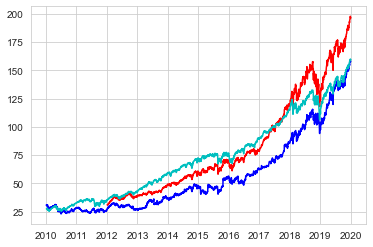

In [25]:
pred_msft_etf = st_close.iloc[0]['MSFT'] * np.cumprod(msft_etf+1)
pred_msft_ind = st_close.loc[pred_msft_etf.index[0]:]['MSFT'].iloc[0] * np.cumprod(msft_spx+1)
plt.plot(pred_msft_etf, 'r')
plt.plot(st_close['MSFT'], 'b')
plt.plot(pred_msft_ind, 'c')

In [26]:
def regress_pca(stock,pca_factors): 
    pca_f = PCA(n_components = 1)
    pca_f.fit(pca_factors)
    features = pca_f.transform(pca_factors)
    features = pd.DataFrame(features,index=pca_factors.index,columns=['etf_pca1'])
    x_pca = sm.add_constant(features)
    y = stock
    lr = sm.OLS(y,x_pca)
    results = lr.fit()
    alpha = results.params[0]
    beta1 = results.params[1]
    res = y - beta1 * x_pca.iloc[:,1] -alpha
    #beta2 = results.params[2]
    return alpha,beta1,res

def calc_ar1(residual): 
    ar1 = ARIMA(residual,order=(1,0,0)).fit()
    ar1_a = ar1.params[0]
    ar1_b = ar1.params[1]
    ar1_res  = ar1.resid
    return ar1_a,ar1_b,ar1_res

def compute_s_score(a,b,r):
    m = r.mean()
    if b > 0: 
        std_r_eq = r.std()/np.sqrt(2 * b)
    else: 
        std_r_eq =  r.std()/-np.sqrt(2 * abs(b))
    s = (r[-1]- m)/std_r_eq
    return s,std_r_eq,m

def calculate_signals(s,b,window): 
    signal = pd.DataFrame(columns = s.columns, index = s.index[window:])
    for i in range(0,s.shape[1]): 
        print('running for'+ " " + s.columns[i])
        curr_s = s.iloc[:,i]
        for j in range(window,s.shape[0]-20):
            if(j%200 == 0): 
                print("currently at iteration: "+ str(j))
            stock = s.iloc[j:j+window,i]
            pca_f = b.iloc[j:j+window,:]
            alpha,beta,res = regress_pca(stock,pca_f)
            ar1_a,ar1_b,ar1_res = calc_ar1(res.mean() - res)
            signal.loc[stock.index[-1],s.columns[i]] = compute_s_score(ar1_a,ar1_b,res)[0]
    return signal
        
    

In [27]:
#test_run
stetf = stETF[stETF['IXN'].notna()]
s = stetf['AAPL']
b = stetf.loc[:,tech_etf]
alpha,beta,residual  = regress_pca(s,b)
a,b,r = calc_ar1(residual)
compute_s_score(a,b,r)

(0.10045317398241754, 0.038964973850395615, -1.97048225493684e-07)

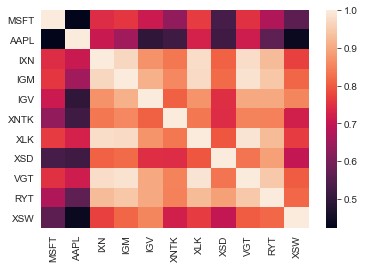

In [28]:
check_cor = stetf[['MSFT','AAPL']]
check_cor = check_cor.join(stetf.loc[:,tech_etf])
corr = check_cor.corr()[['MSFT','AAPL']]
sns.heatmap(check_cor.corr())

In [29]:
s = stetf[['AAPL']]
b = stetf.loc[:,tech_etf]
windows = 60
s_score = calculate_signals(s,b,windows)
s_score = s_score.dropna()
s_score.rename({'AAPL':'s_score'},axis=1,inplace=True)
s_score = s_score.join(stetf['AAPL']+1)

running for AAPL
currently at iteration: 200
currently at iteration: 400
currently at iteration: 600
currently at iteration: 800
currently at iteration: 1000
currently at iteration: 1200
currently at iteration: 1400
currently at iteration: 1600
currently at iteration: 1800


In [75]:
s = s_train.dropna(axis=1)
b = s_train.loc[:,tech_etf]
windows = 60
s_score_all = calculate_signals(s,b,windows)
s_score_all.to_csv('s_score_all_tech_train.csv')

running for SPX
currently at iteration: 200
currently at iteration: 400
currently at iteration: 600
currently at iteration: 800
currently at iteration: 1000
currently at iteration: 1200
running for AAPL
currently at iteration: 200
currently at iteration: 400
currently at iteration: 600
currently at iteration: 800
currently at iteration: 1000
currently at iteration: 1200
running for ADBE
currently at iteration: 200
currently at iteration: 400
currently at iteration: 600
currently at iteration: 800
currently at iteration: 1000
currently at iteration: 1200
running for ADI
currently at iteration: 200
currently at iteration: 400
currently at iteration: 600
currently at iteration: 800
currently at iteration: 1000
currently at iteration: 1200
running for ADSK
currently at iteration: 200
currently at iteration: 400
currently at iteration: 600
currently at iteration: 800
currently at iteration: 1000
currently at iteration: 1200
running for AKAM
currently at iteration: 200
currently at iteration

running for SNPS
currently at iteration: 200
currently at iteration: 400
currently at iteration: 600
currently at iteration: 800
currently at iteration: 1000
currently at iteration: 1200
running for STX
currently at iteration: 200
currently at iteration: 400
currently at iteration: 600
currently at iteration: 800
currently at iteration: 1000
currently at iteration: 1200
running for SWKS
currently at iteration: 200
currently at iteration: 400
currently at iteration: 600
currently at iteration: 800
currently at iteration: 1000
currently at iteration: 1200
running for TEL
currently at iteration: 200
currently at iteration: 400
currently at iteration: 600
currently at iteration: 800
currently at iteration: 1000
currently at iteration: 1200
running for TTWO
currently at iteration: 200
currently at iteration: 400
currently at iteration: 600
currently at iteration: 800
currently at iteration: 1000
currently at iteration: 1200
running for TXN
currently at iteration: 200
currently at iteration:

NameError: name 's_score_all_clean' is not defined

In [211]:
s_score_all = s_score_all[60:]
s_score_all

,SPX,AAPL,ADBE,ADI,ADSK,AKAM,AMAT,AMD,ANSS,APH,...,XRX,IXN,IGM,IGV,XNTK,XLK,XSD,VGT,RYT,XSW
Date,,,,,,,,,,,,,,,,,,,,,
2012-12-17,0.170743,-0.166206,0.604319,-0.39067,-0.139018,-0.0768028,0.11578,0.118124,-0.549528,1.01495,...,0.556416,0.827279,-0.532487,-0.141825,-0.618875,-1.08057,-0.410566,-0.820361,0.487663,-0.531341
2012-12-18,0.0207998,-0.105109,0.411431,-0.345379,-0.0437481,-0.457272,0.0923211,-0.0183714,-0.549052,-0.0172404,...,-0.0141951,0.0890782,-0.34984,0.0674202,-0.00405878,0.101368,-0.047115,0.0447443,-0.497383,-0.182016
2012-12-19,0.236966,0.206102,-0.683993,0.183532,-0.112214,-0.269608,-0.417614,0.0331581,0.51789,0.141134,...,0.241602,0.337068,1.64056,-0.0437219,-0.380489,0.794142,-0.170131,0.483485,-0.0371663,-0.429434
2012-12-20,-0.67272,0.0539075,0.374129,0.0776146,0.04994,-0.273347,-0.11038,-0.240679,-0.344541,0.233355,...,-0.453303,-0.553527,-0.511824,0.0552909,-0.284199,-0.890743,0.0933093,1.38513,-0.473938,0.128182
2012-12-21,-0.0196134,-0.480815,-0.0513312,0.547368,-0.0596531,-0.284672,-0.3864,-0.349238,-0.331651,0.74016,...,-0.293526,-0.3286,-0.887534,-0.46309,0.366201,0.140671,-0.130652,-1.43945,0.121621,1.70047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,-0.0701163,0.133672,0.126378,-0.143887,0.030193,-0.274064,0.243117,-0.465283,0.124001,0.221567,...,-0.0522518,-0.871617,0.0392651,0.0812946,-0.0930918,-0.222848,0.0288982,-0.285784,-0.029186,0.413945
2017-12-26,0.00342875,-1.5962,0.101607,-0.0573909,0.129838,-0.0726744,-0.133559,0.146406,-0.0645841,0.0437205,...,-0.0837341,0.650986,0.102056,-0.266713,0.09917,0.290913,0.0103817,0.44112,0.10623,0.0968562
2017-12-27,-0.0775917,-0.184751,0.0272878,-0.125851,0.0766876,-0.232303,0.216016,0.170947,0.0686969,-0.265564,...,0.172254,0.0676856,-0.0209546,0.0225618,0.391643,0.167873,0.0463109,0.176883,0.0763302,-0.55417


In [213]:
s_tech = pd.read_csv('s_score_all_tech_b.csv').dropna().dropna(axis=1).set_index('Date')
s_tech_train = pd.read_csv('s_score_all_tech_train.csv').dropna().dropna(axis=1).set_index('Date')
train_range = pd.date_range(start = s_tech.index[0], end = "2016-12-31")
s_tech.index = pd.to_datetime(s_tech.index)

s_tech_train = s_tech[s_tech.index.isin(train_range)]
s_tech_test = s_tech.loc[train_range[-1]:]
train_range = pd.date_range(start = s_tech.index[0], end = "2017-12-31")
s_train = stetf[stetf.index.isin(train_range)]
s_test = stetf.loc[s_train.index[-1]:,:]

In [36]:
s_score = pd.DataFrame(s_tech.AAPL).rename({'AAPL':'AAPL_s'},axis=1)
s_score = s_score.join(stetf['AAPL']+1)
s_score_train = pd.DataFrame(s_tech_train.AAPL).rename({'AAPL':'AAPL_s'},axis=1)
s_score_train = s_score_train.join(stetf['AAPL'])

In [69]:
def sim_long_arb(d_cut = -1,u_cut = 1,ret=False): 
    hold = False;
    cap = 1;
    returns = [];
    transaction_date = []
    for i in s_score_train.iterrows():
        date = i[0]
        current_s = i[1][0]
        current_r = i[1][1]
        if(hold == True): 
            returns.append(current_r)
            if(current_s >= u_cut): 
                hold = False
        elif(hold == False and current_s <= d_cut):
            hold = True
    #print(np.mean(returns))
    #print(np.std(returns))
    returns = np.array(returns)
    std = np.std(returns)
    if std == 0: 
        std=1
    sharpe = np.mean(returns)/ std
    if ret == True: 
        return sharpe,returns
    else: 
        return sharpe

def sim_short_arb(d_cut = -1,u_cut = 1,ret=False): 
    short = False;
    cap = 1;
    returns = [];
    transaction_date = []
    for i in s_score_train.iterrows():
        date = i[0]
        current_s = i[1][0]
        current_r = i[1][1] * -1
        if(short == True): 
            returns.append(current_r)
            if(current_s <= d_cut): 
                short = False
        elif(short == False and current_s >= u_cut):
            short = True
    returns = np.array(returns)
    sharpe = np.mean(returns)/np.std(returns)
    if ret==True: 
        return sharpe,returns
    else:
        return sharpe

In [256]:

smin = s_score.iloc[:,0].min()
smax = s_score.iloc[:,0].max()
opt_long = BayesianOptimization(sim_long_arb,{'d_cut':(-3,-1),'u_cut':(1,3)})
opt_short = BayesianOptimization(sim_short_arb,{'d_cut':(-3,-1),'u_cut':(1,3)})
opt_long.maximize(n_iter = 10)
#opt_short.maximize(n_iter=10)

|   iter    |  target   |   d_cut   |   u_cut   |
-------------------------------------------------
|  1        |  1.458    | -1.954    |  1.645    |
|  2        |  0.9325   | -1.233    |  2.708    |
|  3        |  0.913    | -2.929    |  2.968    |
|  4        |  1.429    | -1.481    |  1.902    |
|  5        |  0.9325   | -1.011    |  2.725    |
|  6        |  1.216    | -1.289    |  1.0      |
|  7        | -0.2614   | -2.688    |  1.0      |
|  8        |  1.458    | -1.952    |  1.641    |
|  9        |  0.7949   | -1.0      |  1.568    |
|  10       |  0.9098   | -2.094    |  2.414    |
|  11       |  0.4969   | -3.0      |  2.166    |
|  12       |  0.9941   | -1.582    |  1.539    |
|  13       |  0.9098   | -1.634    |  2.195    |
|  14       |  0.9232   | -1.131    |  2.096    |
|  15       |  1.592    | -1.785    |  1.009    |


In [258]:
print(opt_long.max['params'],opt_long.max['target'])
#print(opt_short.max['params'],opt_short.max['target'])

{'d_cut': -1.7854817284795892, 'u_cut': 1.0093509511552319} 1.5923032125895886


#### parameters are received after optimization for maximum sharpe/sortino ratio over entire dataset, this is to visualize what the "best - case" scenario looks like for a stock


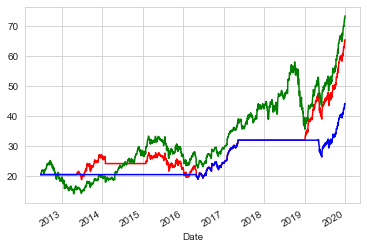

In [40]:

a_sh = [-3.2,1.9]
a_so = [-1.8,2.8]
dc,dr,ds,dso = sim_arbitrage(s_score,a_so[0],a_so[1],20.38)
dcsh,drsh,dssh,dsh = sim_arbitrage(s_score,a_sh[0],a_sh[1],20.38)
dcsh.rename({'value':'sharpe'},axis=1,inplace=True)
test_so_aapl= dc.join(st_close.AAPL)
test_so_aapl=test_so_aapl.join(dcsh)
test_so_aapl.value.plot(color='r')
test_so_aapl.AAPL.plot(color = 'g')
test_so_aapl.sharpe.plot(color='b')

In [70]:
from itertools import product
import random
stock_list = s_tech.columns
def opt_bayesian(s): 
    smin = s.iloc[:,0].min()
    smax = s.iloc[:,0].max()
    print(smin,smax)
    opt_long = BayesianOptimization(sim_long_arb,{'d_cut':(smin,0),'u_cut':(0,smax)})
    try: 
        opt_long.maximize(n_iter=10)
        return opt_long.max['params'],opt_long.max['target']
    except: 
        return -100,-100
    

params = {}
target = {}
for i in stock_list: 
    s_score_train = pd.DataFrame(s_tech_train[i]).rename({i:i+"_s"},axis=1)
    s_score_train = s_score_train.join(stetf[i])
    params[i],target[i] = opt_bayesian(s_score_train)
        
    

-3.2744253615640524 2.7812312078334314
|   iter    |  target   |   d_cut   |   u_cut   |
-------------------------------------------------
|  1        | -0.0779   | -1.015    |  0.6183   |
|  2        |  0.08753  | -2.063    |  1.044    |
|  3        |  0.05704  | -0.3234   |  1.547    |
|  4        |  0.07076  | -1.549    |  0.9161   |
|  5        | -0.01647  | -2.726    |  1.316    |
|  6        |  0.09484  | -2.101    |  0.9924   |
|  7        | -0.2167   | -1.98     |  0.5694   |
|  8        |  0.1431   | -2.303    |  1.123    |
|  9        |  0.124    | -2.217    |  1.395    |
|  10       |  0.04335  | -1.067    |  1.392    |
|  11       |  0.09185  | -1.88     |  1.568    |
|  12       | -0.01647  | -3.126    |  1.029    |
|  13       |  0.116    | -2.214    |  1.797    |
|  14       | -0.2167   | -1.778    |  0.6309   |
|  15       |  0.05731  | -1.875    |  2.198    |
-3.233104026985272 3.529697619602358
|   iter    |  target   |   d_cut   |   u_cut   |
------------------------

|  13       |  0.06407  | -4.679    |  2.485    |
|  14       |  0.06407  | -5.667    |  4.407    |
|  15       |  3.702    | -5.851    |  0.05441  |
-2.5349575576659698 4.004114186684366
|   iter    |  target   |   d_cut   |   u_cut   |
-------------------------------------------------
|  1        |  0.07657  | -0.6731   |  2.572    |
|  2        |  0.0722   | -0.4935   |  3.583    |
|  3        |  0.09468  | -0.06909  |  0.4017   |
|  4        |  0.001987 | -1.712    |  1.733    |
|  5        |  0.05009  | -0.5936   |  0.54     |
|  6        |  0.07679  | -0.6498   |  2.567    |
|  7        |  0.07467  |  0.0      |  1.194    |
|  8        |  0.08286  |  0.0      |  0.0      |
|  9        |  0.03673  | -1.92     |  4.004    |
|  10       |  0.01143  | -2.535    |  0.0      |
|  11       |  0.07911  |  0.0      |  3.049    |
|  12       |  0.07814  | -0.043    |  3.99     |
|  13       |  0.07936  |  0.0      |  2.159    |
|  14       |  0.07477  |  0.0      |  0.6326   |
|  15       

|  9        |  0.1172   |  0.0      |  0.0      |
|  10       |  0.09095  | -3.043    |  2.884    |
|  11       |  0.09876  | -0.1008   |  0.391    |
|  12       |  0.1201   | -0.95     |  1.778    |
|  13       |  0.1126   | -0.8091   |  2.301    |
|  14       |  0.09095  | -2.878    |  2.524    |
|  15       |  0.1717   | -0.6266   |  0.0      |
-7.538971261481692 4.898762251784231
|   iter    |  target   |   d_cut   |   u_cut   |
-------------------------------------------------
|  1        |  0.1758   | -5.218    |  0.6214   |
|  2        |  0.16     | -4.851    |  2.17     |
|  3        |  0.08247  | -1.9      |  2.542    |
|  4        |  0.08247  | -2.274    |  3.01     |
|  5        |  0.0733   | -0.02786  |  3.755    |
|  6        |  0.1758   | -7.539    |  1.569    |
|  7        |  0.16     | -7.539    |  4.899    |
|  8        |  0.006913 | -7.539    |  0.0      |
|  9        |  0.1758   | -5.765    |  1.476    |
|  10       |  0.16     | -7.068    |  2.8      |
|  11       |

|  6        |  0.2117   | -2.902    |  0.04073  |
|  7        |  0.2117   | -2.905    |  0.02292  |
|  8        | -0.1393   | -2.4      |  0.0      |
|  9        |  0.4961   | -3.163    |  0.02039  |
|  10       |  0.3993   | -3.402    |  0.01754  |
|  11       |  0.01741  | -3.263    |  0.167    |
|  12       |  0.4961   | -3.112    |  0.03307  |
|  13       |  0.3993   | -3.581    |  0.02626  |
|  14       |  0.3993   | -3.817    |  0.04239  |
|  15       |  0.01741  | -3.83     |  0.2748   |
-7.50550026184737 2.501099849538001
|   iter    |  target   |   d_cut   |   u_cut   |
-------------------------------------------------
|  1        |  0.08438  | -0.1059   |  1.779    |
|  2        |  0.0701   | -2.871    |  2.335    |
|  3        |  0.08644  | -2.509    |  1.043    |
|  4        |  0.01786  | -5.008    |  0.8641   |
|  5        |  0.08243  | -7.46     |  1.953    |
|  6        |  0.07299  | -1.631    |  1.296    |
|  7        |  0.4458   | -2.297    |  0.0      |
|  8        | 

|  2        |  0.0709   | -2.396    |  2.275    |
|  3        |  0.03277  | -1.019    |  4.129    |
|  4        |  0.03379  | -3.078    |  0.7203   |
|  5        | -0.04069  | -1.922    |  0.6499   |
|  6        |  0.0709   | -2.4      |  2.273    |
|  7        |  0.03739  | -2.973    |  3.005    |
|  8        |  0.03739  | -3.625    |  1.834    |
|  9        |  0.04759  | -1.296    |  2.679    |
|  10       |  0.03739  | -3.625    |  4.862    |
|  11       |  0.02483  |  0.0      |  2.848    |
|  12       |  0.02713  | -1.984    |  3.297    |
|  13       |  0.06163  | -1.846    |  2.023    |
|  14       |  0.02293  |  0.0      |  4.862    |
|  15       |  0.0709   | -2.245    |  4.862    |
-5.803444654500108 3.734600069511716
|   iter    |  target   |   d_cut   |   u_cut   |
-------------------------------------------------
|  1        |  0.02509  | -0.6795   |  1.738    |
|  2        |  0.02407  | -0.6145   |  2.157    |
|  3        | -0.1137   | -3.686    |  1.715    |
|  4        |

|  15       |  0.2362   | -6.34     |  1.198    |
-3.3113584285483464 5.922564225174569
|   iter    |  target   |   d_cut   |   u_cut   |
-------------------------------------------------
|  1        |  0.07545  | -0.8037   |  1.759    |
|  2        |  0.08284  | -1.443    |  2.701    |
|  3        |  0.01193  | -3.033    |  4.487    |
|  4        |  0.02109  | -1.961    |  5.226    |
|  5        |  0.06533  | -0.07691  |  4.749    |
|  6        | -0.3087   | -2.906    |  0.818    |
|  7        |  0.06565  |  0.0      |  2.961    |
|  8        |  0.09115  |  0.0      |  0.0      |
|  9        |  0.06564  |  0.0      |  5.923    |
|  10       |  0.01193  | -3.301    |  5.904    |
|  11       |  0.06171  |  0.0      |  1.213    |
|  12       |  0.07556  | -1.146    |  3.819    |
|  13       |  0.07561  | -0.7648   |  2.709    |
|  14       |  0.06539  | -1.001    |  5.923    |
|  15       | -0.1152   | -0.7536   |  0.0      |
-6.500189705012614 4.8278758130979655
|   iter    |  target   

|  11       |  0.05616  | -1.533    |  2.059    |
|  12       |  0.06119  | -0.4364   |  1.974    |
|  13       |  0.1055   | -3.453    |  2.062    |
|  14       |  0.04624  | -3.019    |  2.136    |
|  15       |  0.03897  | -0.7936   |  0.6217   |
-5.727168842542295 2.7272381844780584
|   iter    |  target   |   d_cut   |   u_cut   |
-------------------------------------------------
|  1        |  0.03313  | -2.378    |  1.037    |
|  2        |  0.066    | -5.243    |  1.97     |
|  3        |  0.4248   | -4.25     |  0.7906   |
|  4        |  0.01279  | -2.249    |  0.3112   |
|  5        |  0.03501  | -1.668    |  1.23     |
|  6        |  0.0261   | -4.521    |  0.1268   |
|  7        |  0.01908  | -3.216    |  1.107    |
|  8        | -0.006312 | -3.506    |  0.07422  |
|  9        |  0.05447  | -2.803    |  2.179    |
|  10       |  0.06794  | -1.795    |  2.717    |
|  11       |  0.07007  | -1.25     |  1.276    |
|  12       |  0.03194  | -4.194    |  0.8341   |
|  13       

|  8        |  1.445    | -5.088    |  0.0      |
|  9        |  0.1493   | -5.081    |  1.718    |
|  10       |  1.445    | -4.87     |  0.0      |
|  11       |  1.445    | -4.183    |  0.0      |
|  12       |  1.445    | -3.491    |  0.0      |
|  13       |  0.3222   | -2.75     |  0.0      |
|  14       |  0.4165   | -3.742    |  0.453    |
|  15       |  0.1493   | -5.529    |  3.118    |
-4.963326151863724 5.220841526326237
|   iter    |  target   |   d_cut   |   u_cut   |
-------------------------------------------------
|  1        | -1.835    | -4.362    |  0.1056   |
|  2        | -0.04126  | -3.85     |  2.375    |
|  3        | -0.1937   | -1.735    |  0.05555  |
|  4        |  0.084    | -1.293    |  1.412    |
|  5        | -0.2026   | -1.844    |  0.02674  |
|  6        |  0.06966  | -2.114    |  3.459    |
|  7        | -0.04126  | -4.339    |  4.67     |
|  8        |  0.03119  |  0.0      |  3.27     |
|  9        |  0.02797  | -0.6864   |  5.221    |
|  10       |

|  5        |  0.1529   | -2.119    |  0.4318   |
|  6        |  0.09567  | -0.0868   |  0.3465   |
|  7        |  0.1504   | -2.071    |  0.2666   |
|  8        |  0.05762  | -0.8385   |  1.205    |
|  9        |  0.06544  | -3.293    |  3.071    |
|  10       |  0.06217  | -1.563    |  3.516    |
|  11       |  0.06544  | -2.712    |  1.436    |
|  12       |  0.06544  | -3.163    |  3.575    |
|  13       |  0.1504   | -2.315    |  0.2902   |
|  14       |  0.07709  |  0.0      |  0.8788   |
|  15       |  0.1504   | -2.281    |  0.0      |
-7.1616883547496295 3.2651358253864413
|   iter    |  target   |   d_cut   |   u_cut   |
-------------------------------------------------
|  1        |  0.02413  | -2.901    |  1.04     |
|  2        | -0.03389  | -4.529    |  0.3962   |
|  3        | -0.03389  | -5.656    |  0.543    |
|  4        |  0.1216   | -6.783    |  2.804    |
|  5        |  0.1485   | -1.131    |  0.386    |
|  6        |  0.09256  |  0.0      |  1.484    |
|  7       

|  1        |  0.004465 | -6.966    |  1.354    |
|  2        |  0.01459  | -6.747    |  4.193    |
|  3        | -0.06424  | -5.837    |  0.6483   |
|  4        |  10.11    | -7.355    |  0.1398   |
|  5        |  0.0349   | -1.295    |  3.857    |
|  6        | -0.08347  | -2.869    |  0.7853   |
|  7        |  0.004465 | -4.458    |  1.697    |
|  8        |  0.000408 | -2.77     |  1.536    |
|  9        |  0.002181 | -7.095    |  0.01504  |
|  10       |  0.05698  | -1.513    |  1.977    |
|  11       |  0.04181  | -0.3401   |  3.979    |
|  12       |  0.04348  | -0.3313   |  2.534    |
|  13       | -0.06424  | -4.627    |  0.5676   |
|  14       |  0.03973  | -0.5834   |  3.763    |
|  15       |  0.03529  | -2.015    |  2.619    |
-4.746326264915603 5.609522210474385
|   iter    |  target   |   d_cut   |   u_cut   |
-------------------------------------------------
|  1        |  0.000259 | -0.2149   |  1.654    |
|  2        | -0.09404  | -4.321    |  2.751    |
|  3        |

|  14       |  0.0109   | -4.878    |  4.674    |
|  15       |  0.01915  |  0.0      |  0.0      |
-2.49821788036887 1.8320809836184253
|   iter    |  target   |   d_cut   |   u_cut   |
-------------------------------------------------
|  1        |  0.2984   | -2.118    |  0.5282   |
|  2        |  0.02189  | -1.252    |  0.359    |
|  3        |  0.07621  | -0.4377   |  1.72     |
|  4        |  0.1365   | -1.966    |  0.6485   |
|  5        |  0.07424  | -1.379    |  1.663    |
|  6        |  0.2984   | -2.194    |  0.5601   |
|  7        |  0.06591  | -0.341    |  0.4948   |
|  8        | -0.8869   | -2.225    |  0.3523   |
|  9        | -0.1087   | -0.9909   |  0.2031   |
|  10       |  0.04815  | -0.809    |  0.9706   |
|  11       |  0.3397   | -2.209    |  0.565    |
|  12       |  0.3397   | -2.238    |  0.6696   |
|  13       |  0.07577  | -0.5611   |  1.49     |
|  14       |  0.07437  | -1.279    |  1.748    |
|  15       |  0.3397   | -2.343    |  0.6081   |
-3.0419964011

In [96]:
opt_s = pd.DataFrame(index=s_tech.columns,columns = ['d_cut','u_cut','expected_sharpe'])
for i in s_tech.columns: 
    opt_s.loc[i]['d_cut'] = params[i]['d_cut']
    opt_s.loc[i]['u_cut'] = params[i]['u_cut']
    opt_s.loc[i]['expected_sharpe'] = target[i]
    

In [99]:
opt_s_tech = opt_s.loc[opt_s.expected_sharpe < 1,:]
opt_s_tech.head()

,d_cut,u_cut,expected_sharpe
SPX,-2.30289,1.12283,0.143142
AAPL,-2.15775,0.944469,0.176007
ADBE,-0.174991,0,0.113003
ADI,-0.0428269,0.00290873,0.0970038
ADSK,-1.40865,2.65543,0.0687006


In [365]:
s_tech =s_tech.loc[:,s_tech.columns.isin(opt_s_tech.index)]
s_test =s_test.loc[:,s_test.columns.isin(opt_s_tech.index)]
s_tech_test =s_tech_test.loc[:,s_tech_test.columns.isin(opt_s_tech.index)]

In [219]:
daily_signal_sh = pd.DataFrame(columns = list(opt_s_tech.index), index = s_tech_test.index)
daily_signal_so = pd.DataFrame(columns = list(opt_s_tech.index), index = s_tech_test.index)
for column in s_tech_test: 
    sh_buy = s_tech_test[s_tech_test[column]<=opt_s_tech.loc[column,'d_cut']]
    #so_buy = s_tech[s_tech[column]<=opt_s_tech[column][1][0]][column]
    sh_sell = s_tech_test[s_tech_test[column]>=opt_s_tech.loc[column,'u_cut']]
    #so_sell = s_tech[s_tech[column]>=opt_s_tech[column][1][1]][column]
    daily_signal_sh.loc[daily_signal_sh.index.isin(sh_buy.index),column] = "BUY"
    daily_signal_sh.loc[daily_signal_sh.index.isin(sh_sell.index),column] = "SELL"
    #daily_signal_so.loc[daily_signal_so.index.isin(so_buy.index),column] = "BUY"
    #daily_signal_so.loc[daily_signal_so.index.isin(so_sell.index),column] = "SELL"
daily_signal_sh.fillna(0,inplace=True)

In [372]:
s

,AAPL
Date,
2012-01-04,0.005446
2012-01-05,0.010833
2012-01-06,0.010717
2012-01-09,-0.001988
2012-01-10,0.003984
...,...
2019-12-24,0.000986
2019-12-26,0.019840
2019-12-27,-0.000414


In [221]:
daily_signal_sh

,SPX,AAPL,ADBE,ADI,ADSK,AMAT,AMD,ANSS,APH,ATVI,...,VRSN,WDC,XRX,IXN,IGM,IGV,XLK,XSD,VGT,RYT
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0,0,0,SELL,0,SELL,0,0,0,0,...,0,0,SELL,0,0,SELL,0,0,0,0
2017-01-04,0,0,0,BUY,0,0,0,0,SELL,0,...,0,0,0,0,0,SELL,0,BUY,0,0
2017-01-05,0,0,SELL,BUY,0,0,0,0,0,0,...,0,0,0,0,0,SELL,0,BUY,0,0
2017-01-06,0,0,SELL,BUY,0,SELL,0,0,SELL,0,...,0,0,SELL,0,0,SELL,0,BUY,0,0
2017-01-09,0,0,SELL,0,0,BUY,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0,0,0,BUY,0,BUY,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-12-26,0,0,SELL,SELL,0,0,0,0,SELL,0,...,0,0,0,0,0,0,0,0,0,BUY
2019-12-27,0,0,SELL,BUY,0,0,0,0,SELL,0,...,0,0,0,0,0,SELL,0,BUY,0,0


In [139]:
signals = []
for i in daily_signal_sh.iterrows(): 
    date= i[0]
    signals.append(list(i[1])) 
signals = pd.DataFrame(signals,columns = daily_signal)

In [162]:
s_ret_test = stetf.loc[stetf.index.isin(daily_signal_sh.index),stetf.columns.isin(daily_signal_sh.columns)]
s_ret_test = s_ret_test+1

In [388]:
position = pd.DataFrame(index = daily_signal_sh.index,columns = daily_signal_sh.columns)
position.loc[:,:] = 0
cap = 10000
day = 0
pos_record = []
pos_list = []
max_hold = 5
optimal = True
day_ret = []
for i in s_ret_test.iterrows():
    print(pos_list)
    date,ret = i[0],i[1]
    signal = daily_signal_sh.loc[date,:]
    buy_list = list(signal[signal=="BUY"].index)
    sell_list = list(signal[signal=="SELL"].index)
    pos_sorted = opt_s_tech.loc[opt_s_tech.index.isin(position),'expected_sharpe'].sort_values(ascending=False)
    buy_sorted = opt_s_tech.loc[opt_s_tech.index.isin(buy_list),'expected_sharpe'].sort_values(ascending=False)
    sell_sorted = opt_s_tech.loc[opt_s_tech.index.isin(sell_list),'expected_sharpe'].sort_values(ascending=False)

    if len(sell_list) > 0 and any(x in sell_list for x in pos_list): 
        for j in pos_list: 
            if j in sell_sorted: 
                #print("selling: " + j)
                pos_list.remove(j)
    while len(buy_list) > 0 and len(pos_list) < max_hold: 
        #print("buying: "+ 
        if(buy_sorted.index[0] not in pos_list): 
            buy_list.pop(buy_list.index(buy_sorted.index[0]))
            pos_list.append(buy_sorted.index[0])
            buy_sorted = buy_sorted.iloc[1:]
        else:
            buy_list.pop(buy_list.index(buy_sorted.index[0]))
            buy_sorted = buy_sorted.iloc[1:]
    w = 1/len(pos_list)
    position.loc[date,position.columns.isin(pos_list)] = w
    curr_w_mat =  position.loc[date,position.columns.isin(pos_list)]
    curr_corr_mat = stetf.loc[:date,stetf.columns.isin(opt_s_tech.index)].corr()
    print(curr_w_mat)
    day_ret.append((position.loc[date] * ret).sum())
    #print((position.loc[date]*ret).sum())
    #if len(buy_list) > 0 and len(pos_list) >= max_hold: 
    #   for i in buy_sorted: 
    #       if(pos_sorted.iloc[-1]['expected_sharpe'])


[]
IT     0.333333
MU     0.333333
TXN    0.333333
Name: 2017-12-29 00:00:00, dtype: object
['TXN', 'IT', 'MU']
ADBE    0.25
ADI     0.25
MU      0.25
TXN     0.25
Name: 2018-01-02 00:00:00, dtype: object
['TXN', 'MU', 'ADBE', 'ADI']
ADI     0.25
AMAT    0.25
IT      0.25
MU      0.25
Name: 2018-01-03 00:00:00, dtype: object
['MU', 'ADI', 'AMAT', 'IT']
ADI     0.25
AMAT    0.25
ATVI    0.25
TXN     0.25
Name: 2018-01-04 00:00:00, dtype: object
['ADI', 'AMAT', 'TXN', 'ATVI']
AMAT    0.25
ATVI    0.25
MU      0.25
TXN     0.25
Name: 2018-01-05 00:00:00, dtype: object
['AMAT', 'TXN', 'ATVI', 'MU']
ADBE    0.2
AMAT    0.2
ATVI    0.2
MU      0.2
TXN     0.2
Name: 2018-01-08 00:00:00, dtype: object
['AMAT', 'TXN', 'ATVI', 'MU', 'ADBE']
ADI     0.2
AMAT    0.2
ATVI    0.2
IT      0.2
MU      0.2
Name: 2018-01-09 00:00:00, dtype: object
['AMAT', 'ATVI', 'MU', 'ADI', 'IT']
ADI     0.2
AMAT    0.2
ATVI    0.2
IT      0.2
TXN     0.2
Name: 2018-01-10 00:00:00, dtype: object
['AMAT', 'ATVI', 'ADI

['ATVI', 'IBM', 'XSD', 'ADBE', 'ADI']
ADBE    0.2
ADI     0.2
ATVI    0.2
IBM     0.2
XSD     0.2
Name: 2018-04-06 00:00:00, dtype: object
['ATVI', 'IBM', 'XSD', 'ADBE', 'ADI']
ADI     0.2
ATVI    0.2
IBM     0.2
IT      0.2
XSD     0.2
Name: 2018-04-09 00:00:00, dtype: object
['ATVI', 'IBM', 'XSD', 'ADI', 'IT']
ADI     0.2
ATVI    0.2
IBM     0.2
IT      0.2
XSD     0.2
Name: 2018-04-10 00:00:00, dtype: object
['ATVI', 'IBM', 'XSD', 'ADI', 'IT']
ATVI    0.2
IBM     0.2
IT      0.2
TXN     0.2
XSD     0.2
Name: 2018-04-11 00:00:00, dtype: object
['ATVI', 'IBM', 'XSD', 'IT', 'TXN']
ATVI    0.2
IBM     0.2
IT      0.2
TXN     0.2
XSD     0.2
Name: 2018-04-12 00:00:00, dtype: object
['ATVI', 'IBM', 'XSD', 'IT', 'TXN']
ATVI    0.2
AVGO    0.2
IBM     0.2
IT      0.2
XSD     0.2
Name: 2018-04-13 00:00:00, dtype: object
['ATVI', 'IBM', 'XSD', 'IT', 'AVGO']
ATVI    0.2
AVGO    0.2
IBM     0.2
IT      0.2
TXN     0.2
Name: 2018-04-16 00:00:00, dtype: object
['ATVI', 'IBM', 'IT', 'AVGO', 'TXN']

AMAT    0.2
AMD     0.2
ATVI    0.2
IBM     0.2
IGV     0.2
Name: 2018-07-17 00:00:00, dtype: object
['ATVI', 'IBM', 'AMAT', 'AMD', 'IGV']
AMAT    0.2
AMD     0.2
ATVI    0.2
IBM     0.2
IGV     0.2
Name: 2018-07-18 00:00:00, dtype: object
['ATVI', 'IBM', 'AMAT', 'AMD', 'IGV']
AMD     0.25
ATVI    0.25
IBM     0.25
MU      0.25
Name: 2018-07-19 00:00:00, dtype: object
['ATVI', 'IBM', 'AMD', 'MU']
AMD     0.2
ATVI    0.2
IBM     0.2
MU      0.2
TXN     0.2
Name: 2018-07-20 00:00:00, dtype: object
['ATVI', 'IBM', 'AMD', 'MU', 'TXN']
ADBE    0.2
AMD     0.2
ATVI    0.2
IBM     0.2
MU      0.2
Name: 2018-07-23 00:00:00, dtype: object
['ATVI', 'IBM', 'AMD', 'MU', 'ADBE']
AMD     0.25
ATVI    0.25
IBM     0.25
MU      0.25
Name: 2018-07-24 00:00:00, dtype: object
['ATVI', 'IBM', 'AMD', 'MU']
AMD     0.2
ATVI    0.2
IBM     0.2
MU      0.2
RYT     0.2
Name: 2018-07-25 00:00:00, dtype: object
['ATVI', 'IBM', 'AMD', 'MU', 'RYT']
AMD     0.2
ATVI    0.2
IBM     0.2
QCOM    0.2
RYT     0.2
Name: 

ADI     0.2
AMAT    0.2
AMD     0.2
IBM     0.2
IT      0.2
Name: 2018-10-10 00:00:00, dtype: object
['IBM', 'AMD', 'AMAT', 'ADI', 'IT']
ADI     0.2
AMAT    0.2
AMD     0.2
IBM     0.2
IT      0.2
Name: 2018-10-11 00:00:00, dtype: object
['IBM', 'AMD', 'AMAT', 'ADI', 'IT']
AMAT    0.2
AMD     0.2
IBM     0.2
IT      0.2
TXN     0.2
Name: 2018-10-12 00:00:00, dtype: object
['IBM', 'AMD', 'AMAT', 'IT', 'TXN']
AMAT    0.2
AMD     0.2
IBM     0.2
IT      0.2
TXN     0.2
Name: 2018-10-15 00:00:00, dtype: object
['IBM', 'AMD', 'AMAT', 'IT', 'TXN']
ADBE    0.2
AMD     0.2
ATVI    0.2
IBM     0.2
IT      0.2
Name: 2018-10-16 00:00:00, dtype: object
['IBM', 'AMD', 'IT', 'ADBE', 'ATVI']
AMD     0.2
ATVI    0.2
IBM     0.2
IT      0.2
TXN     0.2
Name: 2018-10-17 00:00:00, dtype: object
['IBM', 'AMD', 'IT', 'ATVI', 'TXN']
AMD     0.2
ATVI    0.2
IBM     0.2
IT      0.2
TXN     0.2
Name: 2018-10-18 00:00:00, dtype: object
['IBM', 'AMD', 'IT', 'ATVI', 'TXN']
AMAT    0.2
AMD     0.2
ATVI    0.2
IBM 

Name: 2019-01-22 00:00:00, dtype: object
['IBM', 'AMD', 'VRSN', 'AMAT', 'ADBE']
ADBE    0.2
AMAT    0.2
AMD     0.2
IBM     0.2
VRSN    0.2
Name: 2019-01-23 00:00:00, dtype: object
['IBM', 'AMD', 'VRSN', 'AMAT', 'ADBE']
AMAT    0.2
AMD     0.2
IBM     0.2
LRCX    0.2
VRSN    0.2
Name: 2019-01-24 00:00:00, dtype: object
['IBM', 'AMD', 'VRSN', 'AMAT', 'LRCX']
AMAT    0.2
AMD     0.2
IBM     0.2
LRCX    0.2
VRSN    0.2
Name: 2019-01-25 00:00:00, dtype: object
['IBM', 'AMD', 'VRSN', 'AMAT', 'LRCX']
AMAT    0.2
AMD     0.2
IBM     0.2
LRCX    0.2
VRSN    0.2
Name: 2019-01-28 00:00:00, dtype: object
['IBM', 'AMD', 'VRSN', 'AMAT', 'LRCX']
AMAT    0.2
AMD     0.2
IBM     0.2
LRCX    0.2
VRSN    0.2
Name: 2019-01-29 00:00:00, dtype: object
['IBM', 'AMD', 'VRSN', 'AMAT', 'LRCX']
AMAT    0.2
AMD     0.2
IBM     0.2
LRCX    0.2
VRSN    0.2
Name: 2019-01-30 00:00:00, dtype: object
['IBM', 'AMD', 'VRSN', 'AMAT', 'LRCX']
AMAT    0.2
AMD     0.2
IBM     0.2
LRCX    0.2
VRSN    0.2
Name: 2019-01-31 00:

AMAT    0.2
AMD     0.2
IBM     0.2
LRCX    0.2
VRSN    0.2
Name: 2019-04-26 00:00:00, dtype: object
['IBM', 'AMD', 'VRSN', 'AMAT', 'LRCX']
AMAT    0.2
AMD     0.2
IBM     0.2
LRCX    0.2
VRSN    0.2
Name: 2019-04-29 00:00:00, dtype: object
['IBM', 'AMD', 'VRSN', 'AMAT', 'LRCX']
AMAT    0.2
AMD     0.2
IBM     0.2
LRCX    0.2
VRSN    0.2
Name: 2019-04-30 00:00:00, dtype: object
['IBM', 'AMD', 'VRSN', 'AMAT', 'LRCX']
AMAT    0.2
AMD     0.2
IBM     0.2
LRCX    0.2
VRSN    0.2
Name: 2019-05-01 00:00:00, dtype: object
['IBM', 'AMD', 'VRSN', 'AMAT', 'LRCX']
AMAT    0.2
AMD     0.2
IBM     0.2
LRCX    0.2
VRSN    0.2
Name: 2019-05-02 00:00:00, dtype: object
['IBM', 'AMD', 'VRSN', 'AMAT', 'LRCX']
AMAT    0.2
AMD     0.2
IBM     0.2
LRCX    0.2
VRSN    0.2
Name: 2019-05-03 00:00:00, dtype: object
['IBM', 'AMD', 'VRSN', 'AMAT', 'LRCX']
AMAT    0.2
AMD     0.2
IBM     0.2
LRCX    0.2
VRSN    0.2
Name: 2019-05-06 00:00:00, dtype: object
['IBM', 'AMD', 'VRSN', 'AMAT', 'LRCX']
AMAT    0.2
AMD     

AMAT    0.2
AMD     0.2
IBM     0.2
ORCL    0.2
VRSN    0.2
Name: 2019-07-24 00:00:00, dtype: object
['IBM', 'AMD', 'VRSN', 'ORCL', 'AMAT']
AMD     0.2
CTXS    0.2
IBM     0.2
ORCL    0.2
VRSN    0.2
Name: 2019-07-25 00:00:00, dtype: object
['IBM', 'AMD', 'VRSN', 'ORCL', 'CTXS']
AMD     0.2
IBM     0.2
ORCL    0.2
TXN     0.2
VRSN    0.2
Name: 2019-07-26 00:00:00, dtype: object
['IBM', 'AMD', 'VRSN', 'ORCL', 'TXN']
AMAT    0.2
AMD     0.2
IBM     0.2
ORCL    0.2
VRSN    0.2
Name: 2019-07-29 00:00:00, dtype: object
['IBM', 'AMD', 'VRSN', 'ORCL', 'AMAT']
AMAT    0.2
AMD     0.2
IBM     0.2
ORCL    0.2
VRSN    0.2
Name: 2019-07-30 00:00:00, dtype: object
['IBM', 'AMD', 'VRSN', 'ORCL', 'AMAT']
AMAT    0.2
AMD     0.2
IBM     0.2
ORCL    0.2
VRSN    0.2
Name: 2019-07-31 00:00:00, dtype: object
['IBM', 'AMD', 'VRSN', 'ORCL', 'AMAT']
AMD     0.2
IBM     0.2
ORCL    0.2
VRSN    0.2
RYT     0.2
Name: 2019-08-01 00:00:00, dtype: object
['IBM', 'AMD', 'VRSN', 'ORCL', 'RYT']
AMD     0.2
IBM     0.

ADBE    0.2
AMD     0.2
IBM     0.2
ORCL    0.2
IGV     0.2
Name: 2019-10-21 00:00:00, dtype: object
['IBM', 'AMD', 'ORCL', 'IGV', 'ADBE']
ADBE    0.2
AMD     0.2
IBM     0.2
ORCL    0.2
IGV     0.2
Name: 2019-10-22 00:00:00, dtype: object
['IBM', 'AMD', 'ORCL', 'IGV', 'ADBE']
ADBE    0.2
AMD     0.2
IBM     0.2
ORCL    0.2
TXN     0.2
Name: 2019-10-23 00:00:00, dtype: object
['IBM', 'AMD', 'ORCL', 'ADBE', 'TXN']
AMD     0.2
IBM     0.2
LRCX    0.2
ORCL    0.2
TXN     0.2
Name: 2019-10-24 00:00:00, dtype: object
['IBM', 'AMD', 'ORCL', 'TXN', 'LRCX']
AMD     0.2
AVGO    0.2
IBM     0.2
LRCX    0.2
ORCL    0.2
Name: 2019-10-25 00:00:00, dtype: object
['IBM', 'AMD', 'ORCL', 'LRCX', 'AVGO']
AMD     0.2
IBM     0.2
LRCX    0.2
ORCL    0.2
RYT     0.2
Name: 2019-10-28 00:00:00, dtype: object
['IBM', 'AMD', 'ORCL', 'LRCX', 'RYT']
AMD     0.2
IBM     0.2
LRCX    0.2
MU      0.2
ORCL    0.2
Name: 2019-10-29 00:00:00, dtype: object
['IBM', 'AMD', 'ORCL', 'LRCX', 'MU']
AMD     0.2
IBM     0.2
LRC

In [380]:
stetf.columns

Index(['SPX', 'AAPL', 'ADBE', 'ADI', 'ADSK', 'AKAM', 'AMAT', 'AMD', 'ANET',
       'ANSS', 'APH', 'ATVI', 'AVGO', 'CDNS', 'CDW', 'CERN', 'CRM', 'CSCO',
       'CTSH', 'CTXS', 'EA', 'FB', 'FFIV', 'FLIR', 'FTNT', 'FTV', 'GLW',
       'GOOG', 'GRMN', 'HPE', 'HPQ', 'IBM', 'INTC', 'INTU', 'IPGP', 'IT',
       'JNPR', 'KEYS', 'KLAC', 'LDOS', 'LRCX', 'MCHP', 'MSFT', 'MSI', 'MU',
       'MXIM', 'NOW', 'NTAP', 'NVDA', 'ORCL', 'PAYC', 'QCOM', 'QRVO', 'SNPS',
       'STX', 'SWKS', 'TEL', 'TTWO', 'TWTR', 'TXN', 'TYL', 'VRSN', 'WDC',
       'XLNX', 'XRX', 'IXN', 'IGM', 'IGV', 'XNTK', 'XLK', 'XSD', 'VGT', 'RYT',
       'XSW'],
      dtype='object')

In [385]:
date

Timestamp('2017-12-29 00:00:00')

In [386]:
stetf.loc[:date,stetf.columns.isin(opt_s_tech.index)].corr()

,SPX,AAPL,ADBE,ADI,ADSK,AMAT,AMD,ANSS,APH,ATVI,...,VRSN,WDC,XRX,IXN,IGM,IGV,XLK,XSD,VGT,RYT
SPX,1.000000,0.499188,0.594147,0.644227,0.565462,0.593009,0.338133,0.585949,0.673878,0.441272,...,0.488860,0.496786,0.553337,0.893012,0.898758,0.825495,0.896481,0.731580,0.893452,0.886217
AAPL,0.499188,1.000000,0.271538,0.368080,0.280932,0.348581,0.190162,0.291533,0.325353,0.254587,...,0.251950,0.243311,0.242832,0.661370,0.590075,0.418257,0.679928,0.443192,0.666070,0.481238
ADBE,0.594147,0.271538,1.000000,0.450842,0.518790,0.445061,0.234367,0.437328,0.440057,0.372887,...,0.335900,0.322831,0.313715,0.614138,0.641465,0.737268,0.605635,0.512221,0.627623,0.636175
ADI,0.644227,0.368080,0.450842,1.000000,0.442848,0.605444,0.338502,0.418757,0.533568,0.347259,...,0.339274,0.411793,0.394644,0.671478,0.684209,0.626686,0.670662,0.790489,0.688775,0.745427
ADSK,0.565462,0.280932,0.518790,0.442848,1.000000,0.472110,0.248225,0.464498,0.430148,0.313490,...,0.363146,0.380754,0.324067,0.583634,0.609253,0.673004,0.569617,0.541065,0.600907,0.642176
AMAT,0.593009,0.348581,0.445061,0.605444,0.472110,1.000000,0.333088,0.414304,0.494903,0.359079,...,0.339470,0.414486,0.380419,0.632601,0.649808,0.602470,0.624404,0.701226,0.652158,0.702306
AMD,0.338133,0.190162,0.234367,0.338502,0.248225,0.333088,1.000000,0.212686,0.258275,0.197678,...,0.204428,0.222101,0.264001,0.342116,0.361158,0.339212,0.334858,0.474481,0.357554,0.403031
ANSS,0.585949,0.291533,0.437328,0.418757,0.464498,0.414304,0.212686,1.000000,0.489795,0.295397,...,0.323233,0.347019,0.351485,0.571958,0.596843,0.640805,0.566091,0.513173,0.589025,0.610033
APH,0.673878,0.325353,0.440057,0.533568,0.430148,0.494903,0.258275,0.489795,1.000000,0.329713,...,0.373944,0.384840,0.432273,0.655430,0.666203,0.637550,0.649449,0.631525,0.664190,0.709096
ATVI,0.441272,0.254587,0.372887,0.347259,0.313490,0.359079,0.197678,0.295397,0.329713,1.000000,...,0.287762,0.256047,0.240252,0.467238,0.498299,0.532067,0.477418,0.417421,0.486201,0.486201


sharpe ratios: 
mean_reversion    1.367254
SPX               0.709263
dtype: float64


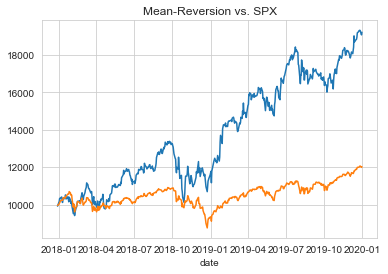

In [367]:
algo_return = pd.DataFrame(10000*np.cumprod(day_ret),index = s_ret_test.index,columns = ["mean_reversion"])
algo_return = algo_return.join((10000* np.cumprod(s_ret_test['SPX'])))
plt.plot(algo_return)
plt.xlabel('date')
plt.title('Mean-Reversion vs. SPX')
print("sharpe ratios: ")
print(algo_return.pct_change()[1:].mean() * np.sqrt(252)/algo_return.pct_change()[1:].std())

In [370]:
from numpy.linalg import inv,pinv
from scipy.optimize import minimize

In [ ]:
'''''
opt_s_tech = pd.DataFrame(columns=s_tech_train.columns, index=('sharpe_opt','sortino_opt'))
for column in s_tech_train:
    print('currently on: ' + str(column))
    s_score = pd.DataFrame(s_tech.AAPL).rename({column: str(column)+"_s"},axis=1)
    s_score = s_score.join(stetf[str(column)]+1)
    curr_sh,curr_so =opt_grid_params(s_score) 
    opt_s_tech[column]  = [list(curr_sh),list(curr_so)]
''''''

In [294]:
position[position['ADBE'] != 0]

,SPX,AAPL,ADBE,ADI,ADSK,AMAT,AMD,ANSS,APH,ATVI,...,VRSN,WDC,XRX,IXN,IGM,IGV,XLK,XSD,VGT,RYT
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,0,0,0.25,0.25,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-08,0,0,0.2,0,0,0.2,0,0,0,0.2,...,0,0,0,0,0,0,0,0,0,0
2018-01-16,0,0,0.2,0.2,0,0.2,0,0,0,0.2,...,0,0,0,0,0,0,0,0.2,0,0
2018-01-17,0,0,0.333333,0,0,0,0,0,0,0.333333,...,0,0,0,0,0,0,0,0.333333,0,0
2018-01-30,0,0,0.2,0.2,0,0.2,0,0,0,0.2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-02,0,0,0.2,0,0,0,0.2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-10-03,0,0,0.2,0,0,0,0.2,0,0,0,...,0,0,0,0,0,0,0,0,0,0.2
2019-10-21,0,0,0.2,0,0,0,0.2,0,0,0,...,0,0,0,0,0,0.2,0,0,0,0


In [389]:
opt_s_tech

,d_cut,u_cut,expected_sharpe
SPX,-2.30289,1.12283,0.143142
AAPL,-2.15775,0.944469,0.176007
ADBE,-0.174991,0,0.113003
ADI,-0.0428269,0.00290873,0.0970038
ADSK,-1.40865,2.65543,0.0687006
AMAT,-0.0690854,0.401721,0.0946837
AMD,-2.26694,1.82445,0.0777932
ANSS,-3.603,2.81012,0.189295
APH,-2.71552,0,0.971763
ATVI,-0.198064,1.40588,0.0863611


In [39]:
''''
from itertools import product
import random
def opt_grid_params(s_score):
    metrics = metrics = pd.DataFrame(columns=['cap','mean_ret','std','sharpe','sortino','buy_s','cut_s'])
    params = list(product(params_b,params_c))
    params = random.sample(params,60)
    for b in params: 
        dc,dr,ds,dso = sim_arbitrage(s_score,b[0],b[1],1)
        metrics = metrics.append({'cap':dc.value[-1],'mean_ret':dr.mean()[0],'std':dr.std()[0],'sharpe':ds[0],'sortino':dso[0],'buy_s':b[0],'cut_s':b[1]},ignore_index = True)
    metrics_sh = metrics[metrics.sharpe == metrics.sharpe.max()]
    metrics_so = metrics[metrics.sortino == metrics.sortino.max()]
    print(metrics_sh)
    print(metrics_so)
    sh = metrics_sh.iloc[0][['buy_s','cut_s']]
    so = metrics_so.iloc[0][['buy_s','cut_s']]
    return sh,so
    
def sim_arbitrage(s_score,buy_s,cut_s,cap=1): 
    daily_cap = []
    long = False
    for i in s_score.iterrows(): 
        curr_d = i[0]
        curr_s = i[1][0]
        curr_r = i[1][1]
        daily_cap.append(cap)
        if long == True: 
            cap = cap * curr_r
            if curr_s > cut_s: 
                long = False

        #elif short == True: 
        #    cap = cap * (((curr_r - 1) * -1) + 1)
        #    if curr_s <= -.5: 
        #        short = False

        if curr_s <= buy_s: 
            long = True
        #elif curr_s > 1.25: 
        #    short = True
        
    daily_cap = pd.DataFrame(daily_cap,index = s_score.index,columns= ['value'])
    daily_ret = daily_cap.pct_change()[1:]
    sharpe = daily_ret.mean()/daily_ret.std()
    sortino = daily_ret.mean()/daily_ret[daily_ret<0].std()
    #if(out == 'sh'): 
    return daily_cap,daily_ret,sharpe,sortino
    #if(out == 'so'): 
       # return sortino
